2023-04-26 17:33:40.933008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 17:33:41.622757: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-04-26 17:33:41.622828: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dle

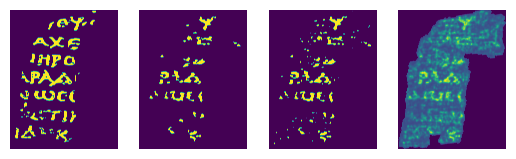

0.6179195625960188

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from train import find_threshold_percentile, fbeta_score, EXP_ID
import cv2
import torch
from torch.nn import functional as F
fold = 0
logdir = "resnetrs50_split3d5x7csn_mixup"
true = np.load(f"../../logs/exp{EXP_ID}/{logdir}/fold{fold}/true.npy")
pred = np.load(f"../../logs/exp{EXP_ID}/{logdir}/fold{fold}/preds.npy")
pred_pp = np.load(f"../../logs/exp{EXP_ID}/{logdir}/fold{fold}/preds_pp.npy")
logit = np.load(f"../../logs/exp{EXP_ID}/{logdir}/fold{fold}/logits.npy")
plt.subplot(141)
plt.axis("off")
plt.imshow(true)
plt.subplot(142)
plt.axis("off")
plt.imshow(pred)
plt.subplot(143)
plt.axis("off")
plt.imshow(pred_pp)
plt.subplot(144)
plt.axis("off")
plt.imshow(logit)
plt.show()
fbeta_score(true, pred)

In [ ]:
pred = np.load(f"../../logs/exp{EXP_ID}/{logdir}/fold{fold}/preds.npy")
num_component, component = cv2.connectedComponents(pred.astype(np.uint8))
size_list = np.array([(c == component) for c in range(1, num_component)])
size_sum = size_list.sum((1, 2))
min_size = np.quantile(size_sum, 0.72)
pred = size_list[size_sum > min_size].sum(0)

# min_size = np.quantile(np.array([(c == component).sum() for c in range(1, num_component)]), 0.72)
# pred = np.zeros_like(pred, np.float32)
# num = 0
# for c in range(1, num_component):
#     p = (component == c)
#     if p.sum() > min_size:
#         pred[p] = 1


# plt.subplot(131)
# plt.axis("off")
# plt.imshow(true)
# plt.subplot(132)
# plt.axis("off")
# plt.imshow(pred)
# plt.subplot(133)
# plt.axis("off")
# plt.imshow(logit)
# plt.show()
fbeta_score(true, pred)

In [ ]:
predictions = (np.load(f"../../logs/exp{EXP_ID}/{logdir}/fold{fold}/oof/oof_0.npy") > 0.36).astype(np.float32)
num_component, component = cv2.connectedComponents(predictions.astype(np.uint8))
size_list = np.array([(c == component) for c in range(1, num_component)])
size_sum = size_list.sum((1, 2))
min_size = np.quantile(size_sum, 0.73)
predictions = size_list[size_sum > min_size].sum(0).astype(np.float32)
predictions = F.interpolate(
    torch.tensor(predictions[None, None]),
    size=pred.shape,
    # scale_factor=32,
    mode="bilinear",
    align_corners=True,
)[0, 0].numpy() > 0.0
plt.imshow(predictions)
plt.show()
new_predictions = np.zeros_like(pred)
new_predictions[:predictions.shape[0], :predictions.shape[1]] = predictions
fbeta_score(true, new_predictions)


In [ ]:
predictions = F.interpolate(
    torch.tensor(pred[None, None]),
    # size=pred.shape,
    scale_factor=1/32,
    mode="bilinear",
    align_corners=True,
)[0, 0].numpy()
predictions = F.interpolate(
    torch.tensor(predictions[None, None]),
    size=pred.shape,
    # scale_factor=32,
    mode="bilinear",
    align_corners=True,
)[0, 0].numpy()
plt.imshow(predictions)
plt.show()
new_predictions = np.zeros_like(pred)
new_predictions[:predictions.shape[0], :predictions.shape[1]] = predictions
fbeta_score(true, new_predictions)


In [ ]:
from train import PatchDataset
from glob import glob
fragment_id = 1
valid_volume_paths = np.asarray(
    sorted(
        glob(
            f"../../input/vesuvius_patches_32_5fold/train/{fragment_id}/surface_volume/**/*.npy",
            recursive=True,
        )
    )
)
